**TITLE :** Identifying the key drivers for Poor Rule of Law in Venezuela and developing targeted interventions for sustanable reduction.


1. Data Collection and processing
2. Define the X (predictor/independent) and the Y (predicted/dependent) variables

3. Model selection : Decision tree

4. Prediction on Training Data:
- Evaluate the performance of Models using RMSE ,MAE ,R Squared and ME
- Hyperparameter tuning (using cross validation to evaluate models perfomance on unseen data)

5. Use of Ensemble methods (Bagging ,boosting and Random Forest ) to increase accuracy and robustness of models

6. Derive the importance of different variables in infleuncing the prediction
- SHAP Explainer

7. Visualizations




# **1. Data Collection and processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import io
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Import the colormap module
!pip install dmba
!pip install shap
!pip install lime
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, \
                            BaggingClassifier, BaggingRegressor, \
                            GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

from dmba import regressionSummary, exhaustive_search
from sklearn.inspection import PartialDependenceDisplay
!pip install scikit-learn
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#for plotting decision trees
import pydotplus as pplus
import graphviz
from IPython.display import Image
from six import StringIO
# if not found: ! pip install six
#for modeling with decision trees
from sklearn.tree import export_graphviz
#This function helps with drawing decision trees using the pydotplus and graphviz libraries
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names

    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features,\
                    class_names=classn, filled=filled)
    graph = pplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

!pip install folium
from urllib.request import urlopen#map
import json
import plotly.express as px
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo = f'{url}/world-countries.json'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c5a5ecda792fd874d582412fa65066f818371cdf71e02d9c69ddfa046e0c52cc
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Colab environment detected.


In [ ]:
WorldDevelopmentIndicators = pd.read_csv('/content/drive/MyDrive/UMD/BUDT704- DATA PROCESSING USING PYTHON/704 Python Group/World Development Indicators.csv')


In [ ]:
#checking the available indiatorNames first
indicatorNames= WorldDevelopmentIndicators['Series Name'].nunique()
indicatorNames
indicatorNamesList= WorldDevelopmentIndicators['Series Name'].unique().tolist()
indicatorNamesList

['Access to clean fuels and technologies for cooking (% of population)',
 'Access to clean fuels and technologies for cooking, rural (% of rural population)',
 'Access to clean fuels and technologies for cooking, urban (% of urban population)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of

In [ ]:
#Data rows and Columns
print("Number of rows:", len(WorldDevelopmentIndicators))
print("Number of columns:", len(WorldDevelopmentIndicators.columns))

Number of rows: 240469
Number of columns: 14


# **2. Define the X (predictor/independent) and the Y (predicted/dependent) variables**

Using the WorldDevelopmentIndicators.csv and select the following variables for year 2014-23 for Venezuela to determine the causes of negative Rule of law rating

Y-Variable: "Rule of Law: Estimate"

X-Variables:

1.Political Stability and Absence of Violence/Terrorism: Estimate

2.Government Effectiveness: Estimate

3.Voice and Accountability: Estimate

4.Regulatory Quality: Estimate

5.Control of Corruption: Estimate
GDP per capita growth

6.Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative)

7.Other Potential Variables: Military expenditure (% of GDP)

8.Net ODA received (% of GNI)

9.Foreign direct investment, net inflows (% of GDP)


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Define the predictor (X) and predicted (Y) variables for Venezuela
venezuela_data = WorldDevelopmentIndicators[WorldDevelopmentIndicators['Country Name'] == 'Venezuela, RB']

# Define the years of interest
years = ['2014 [YR2014]', '2015 [YR2015]','2016 [YR2016]','2017 [YR2017]','2018 [YR2018]','2019 [YR2019]','2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]']


def get_variable_data(df, variable_name, years):
    """Extract data for a given variable and years."""
    variable_data = df[df['Series Name'] == variable_name]

    # Ensure the requested years exist in the data
    if not set(years).issubset(variable_data.columns):
        print(f"Warning: Some years are missing for {variable_name}")

    return variable_data[years]  # Return the data for the specified years


# Define the Y-variable
y_variable_name = 'Rule of Law: Estimate'
y = get_variable_data(venezuela_data, y_variable_name, years) # Pass 'years' to the function

# Define the X-variables
x_variable_names = [
    'Political Stability and Absence of Violence/Terrorism: Estimate',
    'Government Effectiveness: Estimate',
    'Voice and Accountability: Estimate',
    'Regulatory Quality: Estimate',
    'Control of Corruption: Estimate',
    'GDP per capita growth (annual %)',  # Ensure the column name matches exactly
    'Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative)',
    'Military expenditure (% of GDP)',
    'Net ODA received (% of GNI)',
    'Foreign direct investment, net inflows (% of GDP)'
]

# Initialize an empty DataFrame for X-variables
X = pd.DataFrame(columns=years) # Initialize with years as columns

# Extract data for each X-variable and fill the DataFrame
for var_name in x_variable_names:
    var_data = get_variable_data(venezuela_data, var_name, years) # Pass 'years' to the function

    # Check if data for the variable is empty
    if len(var_data) == 0:
        print(f"Warning: No data found for {var_name}, filling with NaN")
        X.loc[var_name] = [float('nan')] * len(years) # Fill with NaN for missing data
    else:
        X.loc[var_name] = var_data.values[0]  # Assuming only one row per variable


# Convert all columns to numeric, forcing errors to NaN (this handles any non-numeric values)
X = X.apply(pd.to_numeric, errors='coerce').T # Transpose X to have years as columns



# Now, X and y contain the relevant data for your model, with consistent shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (10, 10)
Shape of y: (1, 10)


# **3. Model selection : Decision Tree**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.25, random_state=1)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (7, 10)
Shape of X_test: (3, 10)


In [ ]:
## testing

X_train.head()


,Political Stability and Absence of Violence/Terrorism: Estimate,Government Effectiveness: Estimate,Voice and Accountability: Estimate,Regulatory Quality: Estimate,Control of Corruption: Estimate,GDP per capita growth (annual %),"Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative)",Military expenditure (% of GDP),Net ODA received (% of GNI),"Foreign direct investment, net inflows (% of GDP)"
2018 [YR2018],-1.351334,-1.671554,-1.439712,-2.386736,-1.512298,NaN,NaN,0.150854,NaN,NaN
2014 [YR2014],-0.852002,-1.175180,-1.083859,-1.740043,-1.394911,-5.025111,NaN,1.161817,NaN,NaN
2017 [YR2017],-1.252241,-1.427532,-1.217939,-1.984669,-1.385665,NaN,30.211613,2.233332,NaN,NaN
2015 [YR2015],-0.971670,-1.196391,-1.091166,-1.872670,-1.407398,NaN,30.780001,0.941376,NaN,NaN
2021 [YR2021],-1.454970,-1.874598,-1.617731,-2.215186,-1.622940,NaN,NaN,0.313631,NaN,NaN


In [ ]:
# Select the modeling approach for fitting: Decision Tree regression
DTsalesreg=DecisionTreeRegressor(random_state=23)

In [ ]:
# Fit the model on training data
# Since we are using the training portion of the data, we are now "training" our model.
DTsalesreg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=23)

We can visualize the Decision Tree as following:

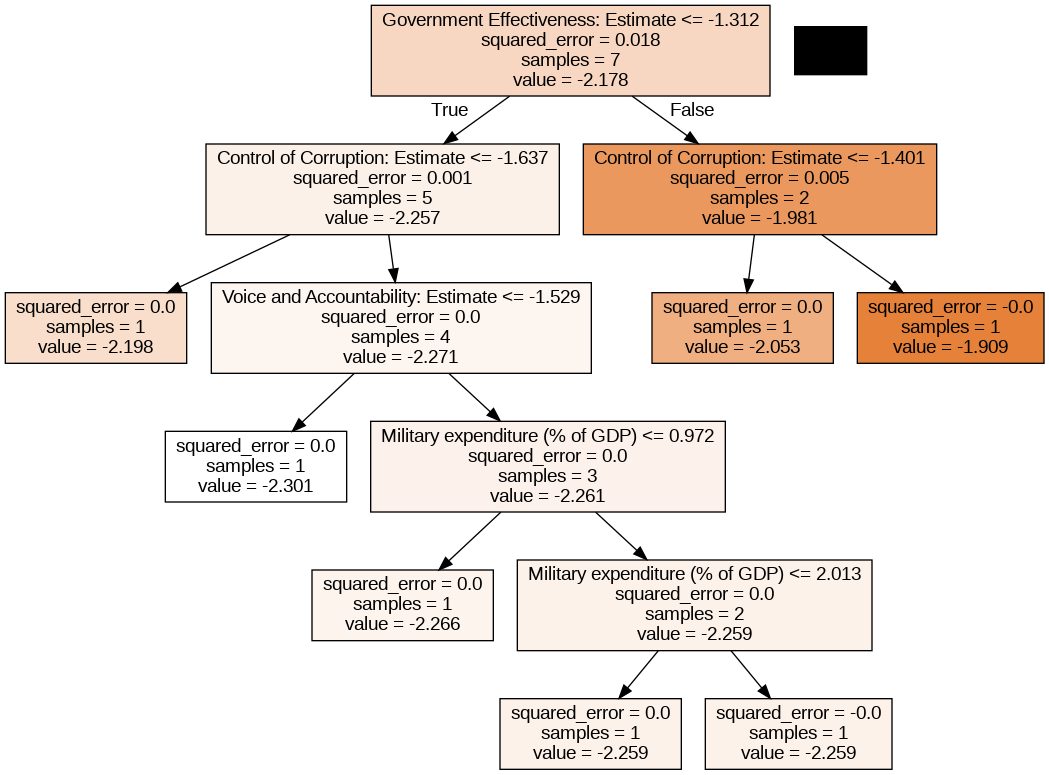

In [ ]:
DTRgraph = print_tree(DTsalesreg, features=['Political Stability and Absence of Violence/Terrorism: Estimate',
    'Government Effectiveness: Estimate',
    'Voice and Accountability: Estimate',
    'Regulatory Quality: Estimate',
    'Control of Corruption: Estimate',
    'GDP per capita growth (annual %)',
    'Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative)',
    'Military expenditure (% of GDP)',
    'Net ODA received (% of GNI)',
    'Foreign direct investment, net inflows (% of GDP)'])
Image(DTRgraph.create_png())

# **4. Prediction on Training Data:**

### Split the data into training and test portions: 25% of data for testing and 75% for training.

In [ ]:
import pandas as pd

y_train = pd.to_numeric(y_train, errors='coerce')

# Fit the model on training data
DTsalesreg.fit(X_train, y_train)

# Predict on training data
DT_predictions_tr = DTsalesreg.predict(X_train)

# Evaluate the training
regressionSummary(y_train, DT_predictions_tr)


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : 0.0000
Mean Absolute Percentage Error (MAPE) : 0.0000


**Interpretation:** RMSE is zero; that is, perfect prediction in training! This is called overfitting, and is problematic.

Cross validation on training data: Induce some variation in the training sample, by doing a 3-fold split

In [ ]:
# prompt: Cross validation on training data: Induce some variation in the training sample, by doing a 3-fold split

# Cross validation on training data
kf = KFold(n_splits=3, shuffle=True, random_state=1)
cv_results = cross_validate(DTsalesreg, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

# Print the results
print("Cross-validation results:")
print("Train MSE:", -cv_results['train_score'])
print("Test MSE:", -cv_results['test_score'])

Cross-validation results:
Train MSE: [0. 0. 0.]
Test MSE: [0.02106465 0.0052958  0.01554167]


Train MSE (0,0,0) and low Test MSE suggect the model has perfectly fit

In [ ]:
# Convert y_test to numeric type before calling regressionSummary
y_test = pd.to_numeric(y_test, errors='coerce')

# How good is the out-of-training-sample (i.e., the test) prediction of the trained model?
DT_predictions_tt = DTsalesreg.predict(X_test)
regressionSummary(y_test, DT_predictions_tt)
#np.sqrt(np.square(DT_predictions_tt-Y_test).mean())


Regression statistics

                      Mean Error (ME) : -0.1278
       Root Mean Squared Error (RMSE) : 0.2123
            Mean Absolute Error (MAE) : 0.1589
          Mean Percentage Error (MPE) : 5.5698
Mean Absolute Percentage Error (MAPE) : 7.0146


Interpretation: RMSE is now not zero and very low; that is, training is not leading to overfitting. However there is a small variance issue .To overcome these limitations ,ensemble methods(Boosting , Random Forest and Bagging) are used

# **5. Ensembles: Bagging, Random Forest, and Boosting;**

We consider refinements to the Decision Tree approach by trying to build many trees and then grouping them together. This is to tackle the "variance" issue we noticed above.:

In [ ]:
# Parameters for the new Decision Tree with ensemble: using i) bagging ii) random forest iii) boosting

# Bagging
bagging_regressor = BaggingRegressor(DecisionTreeRegressor(random_state=23), n_estimators=100, random_state=23)

# Random Forest
random_forest_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=23)

# Boosting
boosting_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=23)


In [ ]:
# Fit the Bagging model : Drop NaN Columns,Fill missing values with mean,Train and make predictions

X_train = X_train.dropna(axis=1, how='all')
X_test = X_test.dropna(axis=1, how='all')

X_test = X_test.reindex(columns=X_train.columns, fill_value=float('nan'))

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Fit the bagging model on training data
bagging_regressor = BaggingRegressor(DecisionTreeRegressor(random_state=23), n_estimators=100, random_state=23)
bagging_regressor.fit(X_train, y_train)

# Make predictions on the training set
bagging_predictions_tr = bagging_regressor.predict(X_train)

# Show regression summary for the training set
regressionSummary(y_train, bagging_predictions_tr)


Regression statistics

                      Mean Error (ME) : 0.0009
       Root Mean Squared Error (RMSE) : 0.0369
            Mean Absolute Error (MAE) : 0.0264
          Mean Percentage Error (MPE) : -0.1264
Mean Absolute Percentage Error (MAPE) : 1.2575


In [ ]:
# Fit the Random Forest model on training data,make predictions and evaluate the model

random_forest_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=23)
random_forest_regressor.fit(X_train, y_train)

rf_predictions = random_forest_regressor.predict(X_test)

regressionSummary(y_test, rf_predictions)


Regression statistics

                      Mean Error (ME) : -0.0642
       Root Mean Squared Error (RMSE) : 0.1193
            Mean Absolute Error (MAE) : 0.1132
          Mean Percentage Error (MPE) : 2.7335
Mean Absolute Percentage Error (MAPE) : 5.0080


In [ ]:
# prompt: get the predicted values and evaluate the training of the new decision tree models:i) bagging ii) random forest iii) boosting

# Fit the boosting model on training data
boosting_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=23)
boosting_regressor.fit(X_train, y_train)

# Make predictions on the training set
boosting_predictions_tr = boosting_regressor.predict(X_train)

# Evaluate the training
regressionSummary(y_train, boosting_predictions_tr)




Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : -0.0000
Mean Absolute Percentage Error (MAPE) : 0.0001


Interpretation: We can see that the ensemble models are pretty good at prediction. RMSE is pretty low, and we don't have to worry about overfitting becuase we collated a bunch of trees, not using just one decision tree.
Here, we see that the boosting training model leads with all regression values for(ME, RMSE ,MAE ,MPE and MAPE)  close to zero .Shows the boosting Model is perfoming exceptionally well.

# **6. SHAP Explainer**

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


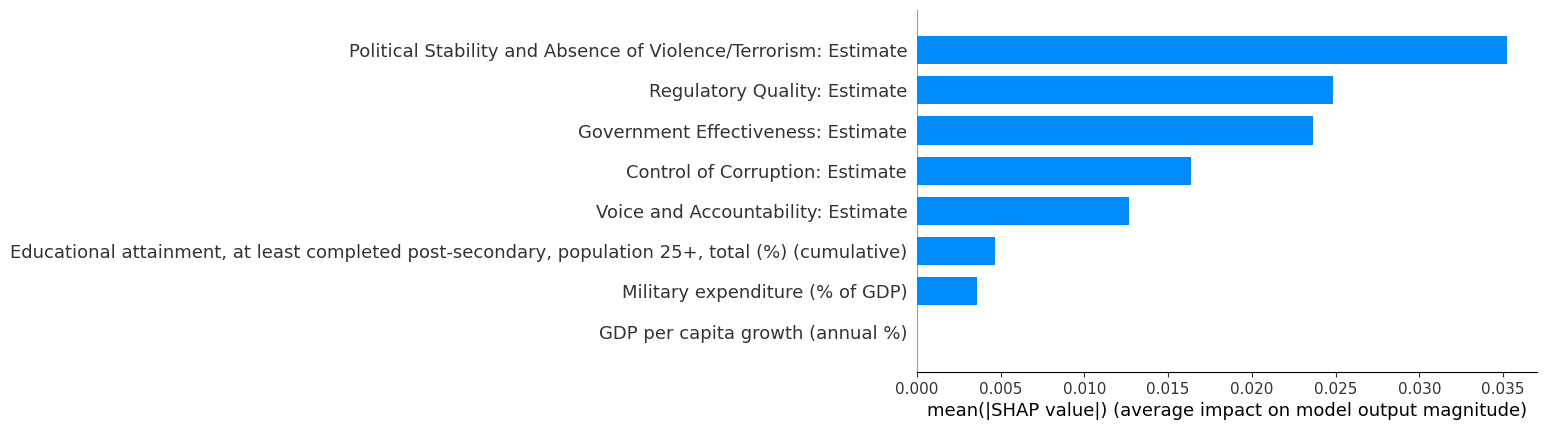

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


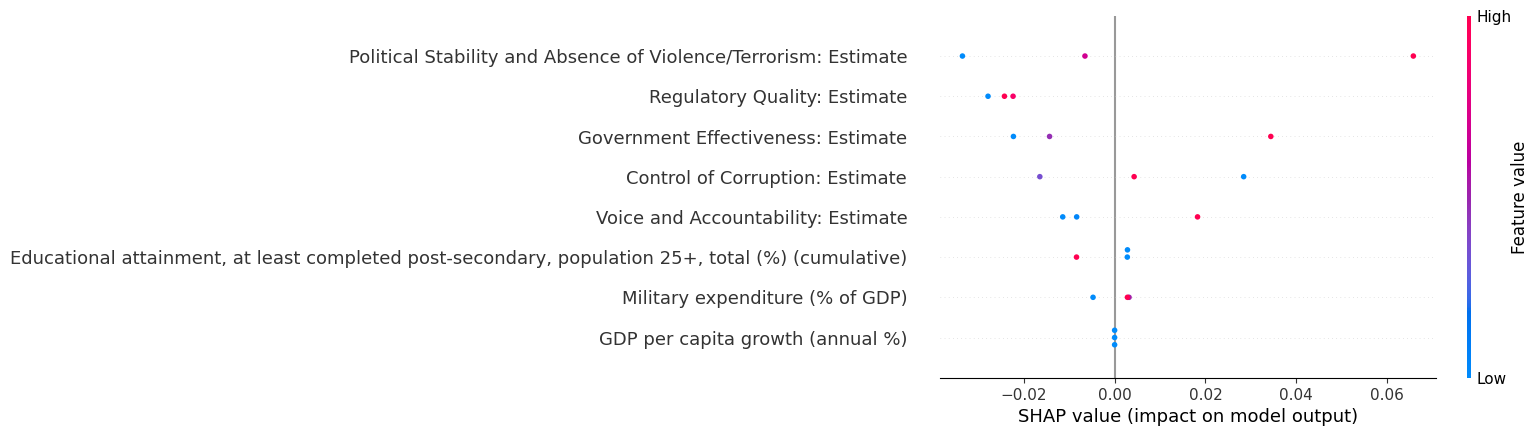

In [ ]:
# prompt:  derive the importance of different variables in infleuncing the prediction.FROM BOOSTING

import shap

# Assuming 'boosting_regressor' is your trained GradientBoostingRegressor
explainer = shap.TreeExplainer(boosting_regressor)
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")

# You can also get a detailed plot showing the impact of each feature for each prediction:
shap.summary_plot(shap_values, X_test)

# **7. Visualizations**

**YEAR 2023: World Map of Average Rule of Law (Estimate)**
- Showing countries above and below the average estimate

In [ ]:
!pip install folium

from urllib.request import urlopen
import json
import pandas as pd
import plotly.express as px

data_to_plot = pd.read_csv('/content/drive/MyDrive/UMD/BUDT704- DATA PROCESSING USING PYTHON/704 Python Group/World Development Indicators.csv')

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo = f'{url}/world-countries.json'

In [ ]:
world_data = pd.read_csv('/content/drive/MyDrive/UMD/BUDT704- DATA PROCESSING USING PYTHON/704 Python Group/World Development Indicators.csv')
wdiselect = world_data[(world_data['Series Name']=='Rule of Law: Estimate') & (world_data['Series Code']=='RL.EST')]
wdiselect.head()


data_to_plot = wdiselect[['Country Code','Series Name', '2023 [YR2023]']]
data_to_plot.head()

,Country Code,Series Name,2023 [YR2023]
725,ARE,Rule of Law: Estimate,0.881900132
1629,AFG,Rule of Law: Estimate,-1.649640918
2533,ALB,Rule of Law: Estimate,-0.164097369
3437,DZA,Rule of Law: Estimate,-0.678364396
4341,ASM,Rule of Law: Estimate,1.212491155


In [ ]:
# Calculate the average Rule of Law
# Convert the column to numeric, forcing errors to be NaN
data_to_plot['2023 [YR2023]'] = pd.to_numeric(data_to_plot['2023 [YR2023]'], errors='coerce')

# Now calculate the mean, ignoring NaN values
average_rule_of_law = data_to_plot['2023 [YR2023]'].mean()

# Create a new column indicating whether the Rule of Law is above or below average
data_to_plot['Rule of Law: Estimate'] = ['Above Average' if value > average_rule_of_law else 'Below Average' for value in data_to_plot['2023 [YR2023]']]

fig = px.choropleth(data_to_plot, geojson=world_geo, locations='Country Code', color='Rule of Law: Estimate',
                           color_discrete_map={'Above Average': 'green', 'Below Average': 'red'},
                           labels={'Rule of Law: Estimate': 'Rule of Law: Estimate (YR2023)'},
                           hover_data=['2023 [YR2023]']
                          )

# Add dropdown menu to filter countries based on Rule of Law
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{"visible": [True]}],  # Show all data
                    label="All",
                )
            ]),
        )
    ]
)

fig.show()

**Identify least rated "Rule of law"countries in the world**

Top 5 Lowly rated countries on Rule of Law - Based on (Average 2019 - 2023)

<ipython-input-34-47b5c3e41d54>:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



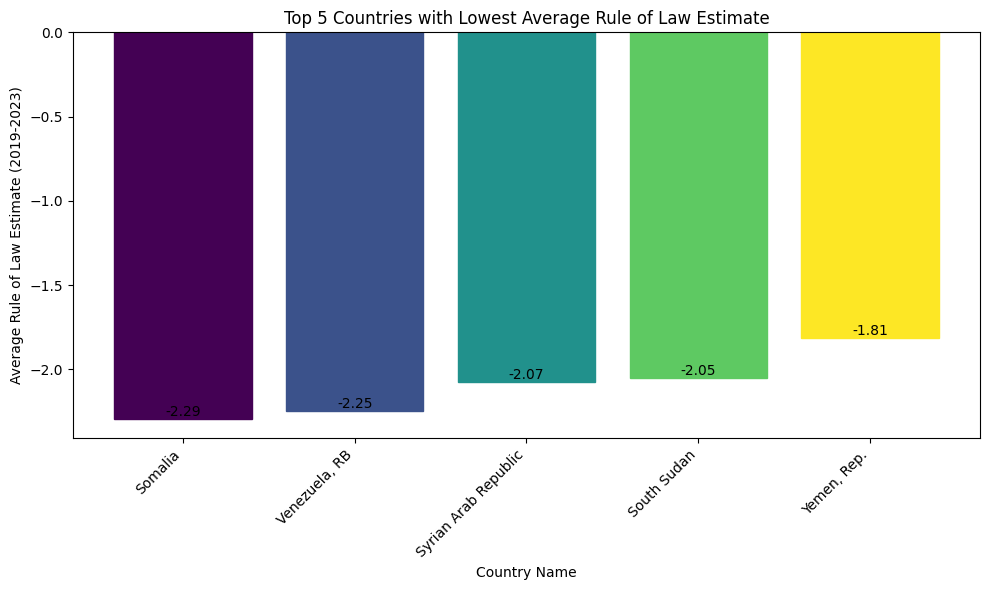

In [ ]:

pd.options.mode.copy_on_write = True

# Calculate the average of 'YR2019' to 'YR2023' for "Rule of Law: Estimate"
rule_of_law_data = WorldDevelopmentIndicators[WorldDevelopmentIndicators['Series Name'] == 'Rule of Law: Estimate']
years = ['2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]']

# Convert the relevant columns to numeric, handling errors
for year in years:
    rule_of_law_data[year] = pd.to_numeric(rule_of_law_data[year], errors='coerce')

rule_of_law_data['Average'] = rule_of_law_data[years].mean(axis=1)

# Sort by average and get top 5 lowest
top_5_lowest = rule_of_law_data.sort_values(by='Average').head(5)

# Create the histogram with different colors
plt.figure(figsize=(10, 6))

# Generate a colormap with the desired number of colors
num_colors = len(top_5_lowest)
colormap = cm.get_cmap('viridis', num_colors)  # You can change 'viridis' to other colormaps

# Create the bars with different colors
bars = plt.bar(top_5_lowest['Country Name'], top_5_lowest['Average'])
for i, bar in enumerate(bars):
    bar.set_color(colormap(i))  # Set color for each bar

 # Annotate bar height
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Country Name')
plt.ylabel('Average Rule of Law Estimate (2019-2023)')
plt.title('Top 5 Countries with Lowest Average Rule of Law Estimate')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Histogram of Control of Corruption: Estimate (2014-2023) in Lowest Rule of Law Estimated Countries (Excluding South Sudan)

In [ ]:
import plotly.express as px
import pandas as pd

# Filter the DataFrame for FIN and VEN and the desired indicator
filtered_data = WorldDevelopmentIndicators[
    (WorldDevelopmentIndicators['Country Code'].isin(['SOM', 'VEN','SYR','YEM'])) &
    (WorldDevelopmentIndicators['Series Name'] == 'Control of Corruption: Estimate')
]
# Select relevant columns and melt the DataFrame
years = ['2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]',
         '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]',
         '2022 [YR2022]', '2023 [YR2023]']
melted_data = pd.melt(
    filtered_data,
    id_vars=['Country Name', 'Country Code'],
    value_vars=years,
    var_name='Year',
    value_name='Control of Corruption: Estimate'
)

# Convert 'Control of Corruption: Estimate' to numeric
melted_data['Control of Corruption: Estimate'] = pd.to_numeric(melted_data['Control of Corruption: Estimate'], errors='coerce')

# Create the histogram
fig = px.histogram(
    melted_data,
    x='Control of Corruption: Estimate',
    color='Country Code',
    nbins=20,  # Adjust the number of bins as needed
    title='Histogram of Control of Corruption: Estimate (2014-2023) in Lowest Rule of Law Estimated Countries (Excluding South Sudan)',
    labels={'Control of Corruption: Estimate': 'Control of Corruption: Estimate'},
    barmode='overlay'  # Overlay the histograms for comparison
)

fig.show()

Top rated countries with High ranking on Rule of law

<ipython-input-36-26a5ca00e7fc>:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



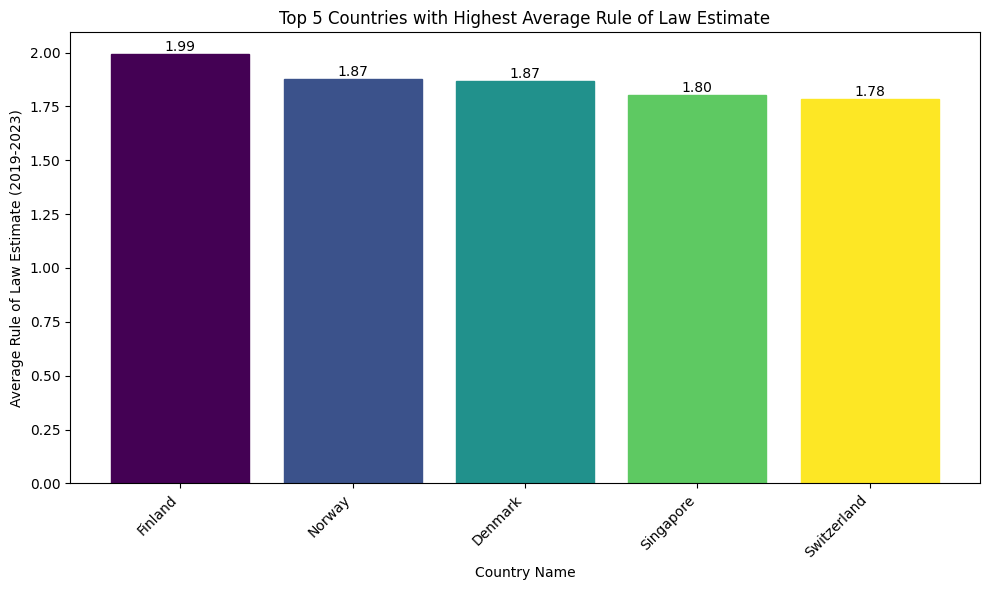

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Import the colormap module

# Assuming your dataframe is named 'WorldDevelopmentIndicators'
# and it's already loaded as in your provided code

# Calculate the average of 'YR2019' to 'YR2023' for "Rule of Law: Estimate"
rule_of_law_data = WorldDevelopmentIndicators[WorldDevelopmentIndicators['Series Name'] == 'Rule of Law: Estimate']
years = ['2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]']

# Convert the relevant columns to numeric, handling errors
for year in years:
    rule_of_law_data[year] = pd.to_numeric(rule_of_law_data[year], errors='coerce')

rule_of_law_data['Average'] = rule_of_law_data[years].mean(axis=1)

# Sort by average in descending order to get top rated countries
top_rated_countries = rule_of_law_data.sort_values(by='Average', ascending=False).head(5)
# Create the bar chart with different colors
plt.figure(figsize=(10, 6))

# Generate a colormap with the desired number of colors
num_colors = len(top_rated_countries)
colormap = cm.get_cmap('viridis', num_colors)  # You can change 'viridis' to other colormaps

# Create the bars with different colors
bars = plt.bar(top_rated_countries['Country Name'], top_rated_countries['Average'])
for i, bar in enumerate(bars):
    bar.set_color(colormap(i))  # Set color for each bar

     # Annotate bar height
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Country Name')
plt.ylabel('Average Rule of Law Estimate (2019-2023)')
plt.title('Top 5 Countries with Highest Average Rule of Law Estimate')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## **8. Line Graph: Comparing Finland and Venezuela**
For Venezuela to copy similar trends to improve on rule of law

## Based on the following variable: "Political Stability and Absence of Violence/Terrorism: Estimate"

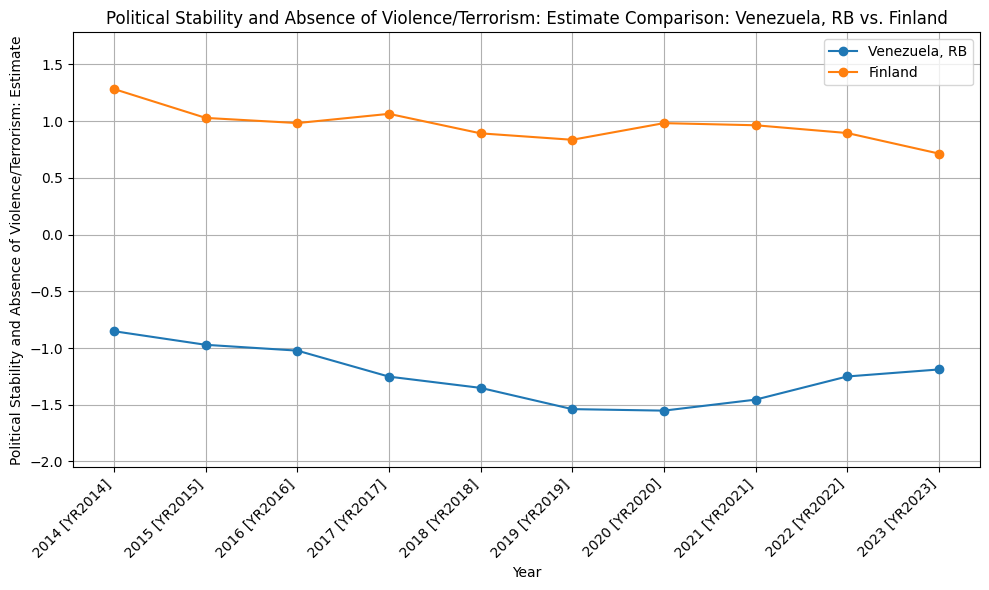

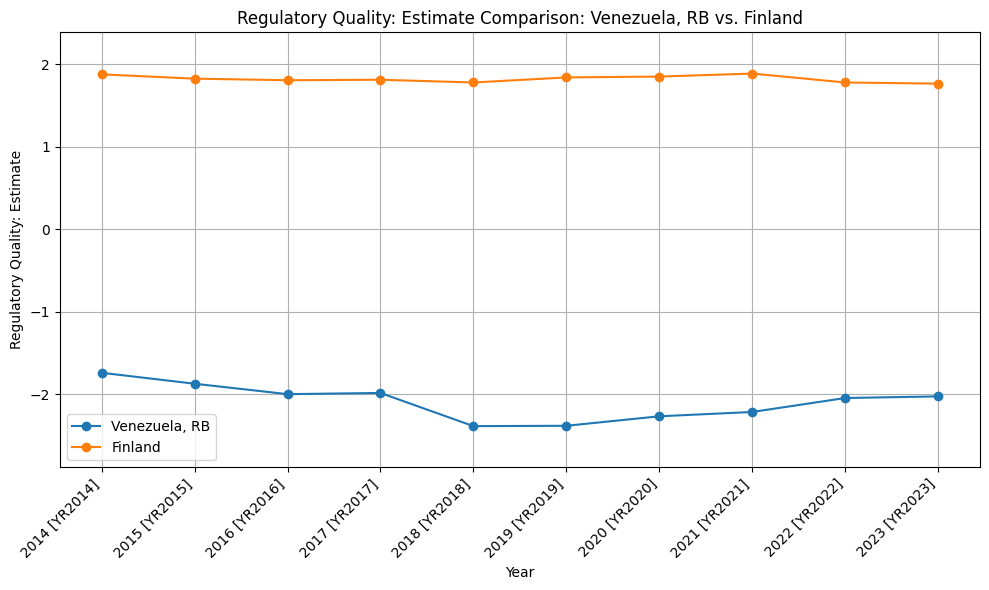

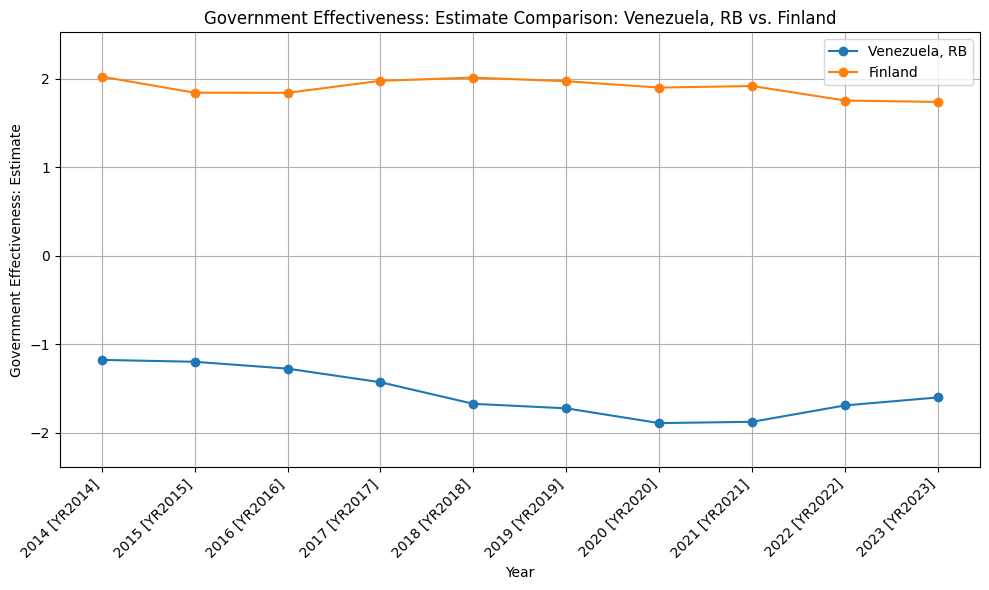

In [ ]:
import matplotlib.pyplot as plt

# Common function: Compare indicators between two countries
def plot_indicator_comparison(df, country1, country2, indicator, years):
    """
    Generate comparison graph for a specific indicator between two countries.
    """
    # Filter data for both countries and the given indicator
    country1_data = df[(df['Country Name'] == country1) & (df['Series Name'] == indicator)]
    country2_data = df[(df['Country Name'] == country2) & (df['Series Name'] == indicator)]

    # Extract available years and corresponding values
    years_available = [year for year in years if year in country1_data.columns and year in country2_data.columns]
    country1_values = [float(country1_data[year].values[0]) for year in years_available]
    country2_values = [float(country2_data[year].values[0]) for year in years_available]

    # Determine unified Y-axis limits
    y_min = min(country1_values + country2_values) - 0.5  # Add padding
    y_max = max(country1_values + country2_values) + 0.5  # Add padding

    # Create graph
    plt.figure(figsize=(10, 6))
    plt.plot(years_available, country1_values, marker='o', label=country1)
    plt.plot(years_available, country2_values, marker='o', label=country2)
    plt.xlabel('Year')
    plt.ylabel(indicator)
    plt.ylim(y_min, y_max)  # Unified Y-axis limits
    plt.title(f'{indicator} Comparison: {country1} vs. {country2}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Define years for comparison
years = ['2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]',
         '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]',
         '2022 [YR2022]', '2023 [YR2023]']

# Define countries for comparison
country1 = 'Venezuela, RB'
country2 = 'Finland'

# List of indicators to compare
indicators = [
    "Political Stability and Absence of Violence/Terrorism: Estimate",
    "Regulatory Quality: Estimate",
    "Government Effectiveness: Estimate"
]

# Generate graphs for each indicator
for indicator in indicators:
    plot_indicator_comparison(WorldDevelopmentIndicators, country1, country2, indicator, years)




# Reference Material

Year-over-year changes for Venezuela:
[-0.11966806699999999, -0.05130636700000002, -0.2292640210000001, -0.09909367499999999, -0.187185288, -0.013323187999999986, 0.09687256799999999, 0.20416378999999996, 0.06177842600000005]


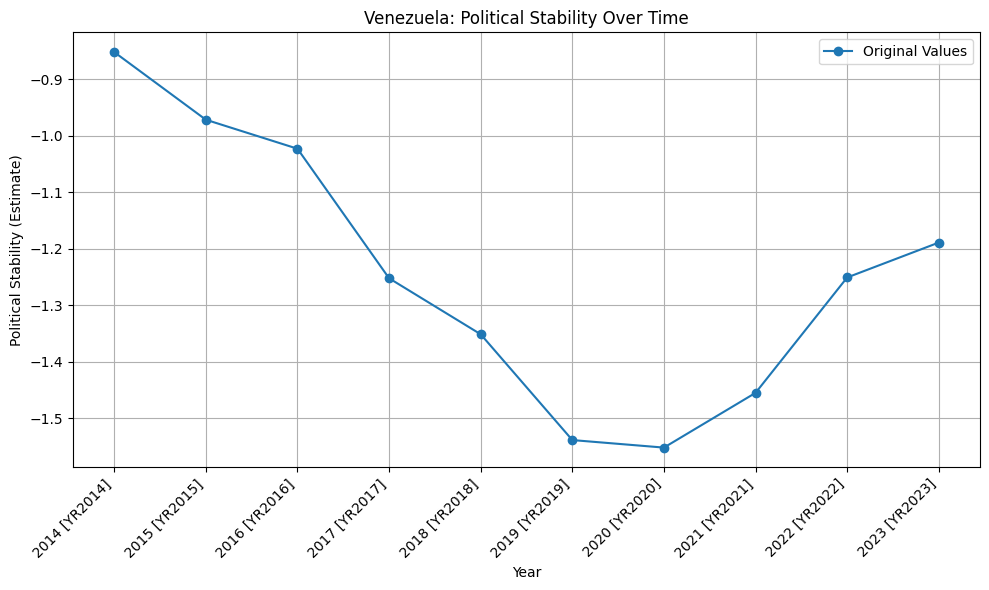

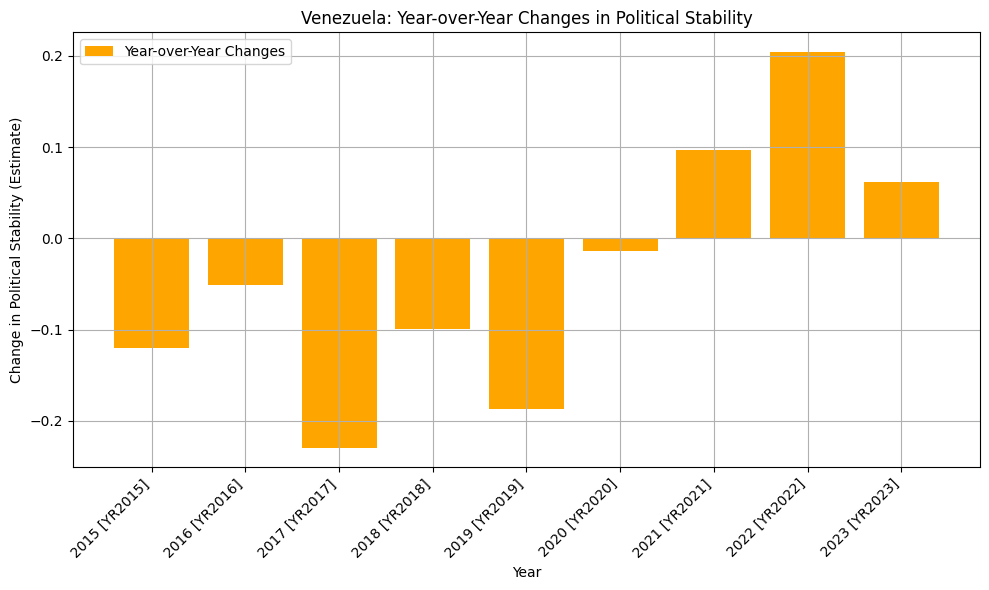

In [ ]:
# Extract Venezuela data
venezuela_data = WorldDevelopmentIndicators[
    (WorldDevelopmentIndicators['Country Name'] == 'Venezuela, RB') &
    (WorldDevelopmentIndicators['Series Name'] == 'Political Stability and Absence of Violence/Terrorism: Estimate')
]

# Extract year-by-year values and convert to numeric
venezuela_values = [float(venezuela_data[year].values[0]) for year in years]

# Calculate year-over-year changes
venezuela_diff = [venezuela_values[i] - venezuela_values[i - 1] for i in range(1, len(venezuela_values))]

# Print the changes
print("Year-over-year changes for Venezuela:")
print(venezuela_diff)

import matplotlib.pyplot as plt

# Plot original values
plt.figure(figsize=(10, 6))
plt.plot(years, venezuela_values, marker='o', label='Original Values')
plt.xlabel('Year')
plt.ylabel('Political Stability (Estimate)')
plt.title('Venezuela: Political Stability Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot year-over-year differences
plt.figure(figsize=(10, 6))
plt.bar(years[1:], venezuela_diff, color='orange', label='Year-over-Year Changes')
plt.xlabel('Year')
plt.ylabel('Change in Political Stability (Estimate)')
plt.title('Venezuela: Year-over-Year Changes in Political Stability')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Year-over-year changes for Finland:
[-0.25419902800000016, -0.04540634199999993, 0.081216336, -0.17191851199999997, -0.05663084900000004, 0.14656627099999997, -0.018549143999999962, -0.06844586100000005, -0.18084341299999995]


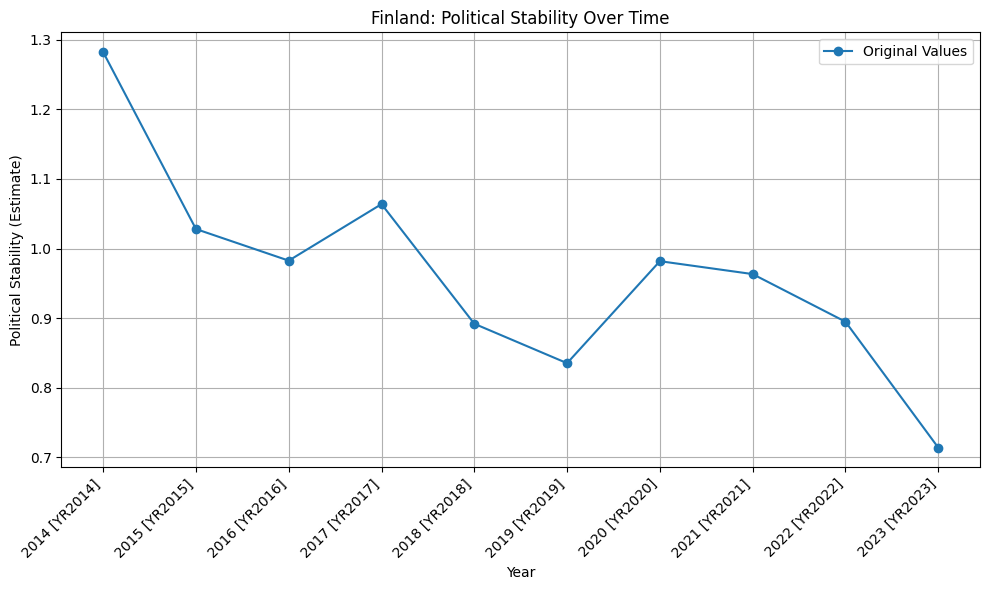

In [ ]:
# Extract Finland data
finland_data = WorldDevelopmentIndicators[
    (WorldDevelopmentIndicators['Country Name'] == 'Finland') &
    (WorldDevelopmentIndicators['Series Name'] == 'Political Stability and Absence of Violence/Terrorism: Estimate')
]

# Extract year-by-year values and convert to numeric
finland_values = [float(finland_data[year].values[0]) for year in years]

# Calculate year-over-year changes
finland_diff = [finland_values[i] - finland_values[i - 1] for i in range(1, len(finland_values))]

# Print the changes
print("Year-over-year changes for Finland:")
print(finland_diff)

# Plot original values
plt.figure(figsize=(10, 6))
plt.plot(years, finland_values, marker='o', label='Original Values')
plt.xlabel('Year')
plt.ylabel('Political Stability (Estimate)')
plt.title('Finland: Political Stability Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

